<div align=right><i>Peter Norvig</i></div>

# Tracking Trump: Electoral Votes Edition

[538](https://projects.fivethirtyeight.com/trump-approval-ratings/) shows presidential approval ratings (currently about 42% (±4) approval and 52% (±4) disapproval). But do approval ratings predict election results? Surely there is a correlation&mdash;popular presidents are more likely to be re-elected. But there are three big caveats:

1. These are  approval polls, not votes. We don't know who  will be on the ballot and what their approval levels will be, we don't know if there is systematic bias in the polling data, and we don't know how many people will vote for a candidate they disapprove of or against a candidate they approve of.

2. This is today, not November 3rd, 2020. Things can change. Key economic, geopolitical, or legal events might happen.

3. These are popular votes, not electoral votes. 

We can't be conclusive about the first two points, but this notebook can take the state-by-state, month-by-month approval data from Morning Consult's
[Tracking Trump](https://morningconsult.com/tracking-trump/) web page and compute electoral votes, under the assumption that Trump wins the electoral votes of states he has positive net approval (and wins half the electoral votes for states where approval exactly equals disapproval).


# TL;DR for policy wonks

As of 1 April 2019, Trump would expect  **180 electoral votes** under these assumptions (recall that you need **270** to win). He's been below 270 every month for the last two years.
I have five ways of understanding the fluidity of the situation:

- **Undecided**: If many voters are undecided, the net approval could change a lot. So I track the number of states for which at least 5% of voters are undecided. At the inauguration in 2017, all 51 states (including DC) had at least 5% undecided; now there are no such states. Overall 4% of voters are undecided. Most people have made up their mind.

- **Variance**: How much are voters changing their minds from month to month in each state?  I track the standard deviation, 𝝈, of the net approval for each state over the last 12 months.

- **Movement**: What's the most a state's net approval could be expected to move, due to random fluctuations (that is, assuming there is no big event that changes people's minds)? I define the maximum expected  **movement** of a state as 1/5 of the undecided voters (i.e. assume the undecided voters broke 60/40 one way or the other) plus 2 standard deviations in the net approval. If all the states had maximum expected movement towards Trump he would take **259** electoral votes, and if the states all swung the other way, he would take **79** electoral votes.

- **Swing state**: I define a swing state as one whose maximum expected movement is greater than the absolute value of the net approval. There are 15 such states now.

- **Margin**: Suppose a future event swings voters in one direction or another uniformly, across the board in all states. How much of a swing would be necessary to change the election outcome? We call that the **margin**. Today **Trump's margin is 7%:** if he got 7% more votes in all states he would be over 270 electoral votes. (This could come, for example, by convincing undecided voters to break for him at a 2% to 1% ratio, and then convincing 3% of disapproving voters to switch to approving.)



# The details for data science nerds

First fetch the Tracking Trump web page and cache it locally, then define the code:

In [1]:
! curl -o evs.html https://morningconsult.com/tracking-trump/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  113k    0  113k    0     0   230k      0 --:--:-- --:--:-- --:--:--  231k


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
import ast
from collections import namedtuple
from IPython.display import display, Markdown
from statistics import stdev

EVs = {
 'Alaska': 3,          'Alabama': 9,              'Arkansas': 6,
 'Arizona': 11,        'California': 55,          'Colorado': 9,
 'Connecticut': 7,     'District of Columbia': 3, 'Delaware': 3,
 'Florida': 29,        'Georgia': 16,             'Hawaii': 4,
 'Iowa': 6,            'Idaho': 4,                'Illinois': 20,
 'Indiana': 11,        'Kansas': 6,               'Kentucky': 8,
 'Louisiana': 8,       'Massachusetts': 11,       'Maryland': 10,
 'Maine': 4,           'Michigan': 16,            'Minnesota': 10,
 'Missouri': 10,       'Mississippi': 6,          'Montana': 3,
 'North Carolina': 15, 'North Dakota': 3,         'Nebraska': 5,
 'New Hampshire': 4,   'New Jersey': 14,          'New Mexico': 5,
 'Nevada': 6,          'New York': 29,            'Ohio': 18,
 'Oklahoma': 7,        'Oregon': 7,               'Pennsylvania': 20,
 'Rhode Island': 4,    'South Carolina': 9,       'South Dakota': 3, 
 'Tennessee': 11,      'Texas': 38,               'Utah': 6,
 'Virginia': 13,       'Vermont': 3,              'Washington': 12,
 'Wisconsin': 10,      'West Virginia': 5,        'Wyoming': 3}

# From https://projects.fivethirtyeight.com/trump-approval-ratings/
# a dict of {date: country-wide net approval}
net_usa = {'1-Jan-17': +10, 
 '1-Feb-17':   0, '1-Mar-17':  -6, '1-Apr-17': -13, '1-May-17': -11,
 '1-Jun-17': -16, '1-Jul-17': -15, '1-Aug-17': -19, '1-Sep-17': -20,
 '1-Oct-17': -17, '1-Nov-17': -19, '1-Dec-17': -18, '1-Jan-18': -18,
 '1-Feb-18': -15, '1-Mar-18': -14, '1-Apr-18': -13, '1-May-18': -12,
 '1-Jun-18': -11, '1-Jul-18': -10, '1-Aug-18': -12, '1-Sep-18': -14,
 '1-Oct-18': -11, '1-Nov-18': -11, '1-Dec-18': -10, '1-Jan-19': -12,
 '1-Feb-19': -16, '1-Mar-19': -11, '1-Apr-19': -11, '1-May-19': -12}

State = namedtuple('State', 'name, ev, apps, diss')
State.__doc__ = '''A State has a name, the number of electoral votes (.ev),
and two dicts of {date: percent}, .apps (approvals) and .diss (disapprovals)'''

def parse_page(filename='evs.html'):
    "Read data from the file and return (list of dates, list of `State`s, last date)."
    # File format: Date headers, then [state, approval, disapproval ...]
    # [["Demographic","1-Jan-17","","1-Feb-17","", ... "1-Apr-19",""],
    #  ["Alabama","62","26","65","29", ... "61","35"], ... ] =>
    # State("Alabama", 9, apps={"1-Jan-17": 62, ...}, diss={"1-Jan-17": 26, ...}), ...
    text   = re.findall(r'\[\[.*?\]\]', open(filename).read())[0]
    table  = ast.literal_eval(text)
    dates  = table[0][1::2]
    states = [State(name, EVs[name], 
                    dict(zip(dates, map(int, numbers[0::2]))),
                    dict(zip(dates, map(int, numbers[1::2]))))
              for (name, *numbers) in table[1:]]
    return dates, states, dates[-1]

dates, states, now = parse_page()

assert len(states) == 51 and sum(s.ev for s in states) == 538

def EV(states, date=now, swing=0):
    "Total electoral votes with net positive approval (plus half the votes for net zero)."
    return sum(s.ev * (1/2 if net(s, date) + swing == 0 else int(net(s, date) + swing > 0))
               for s in states)

def margin(states, date=now):
    "What's the least swing that would lead to a majority?"
    return next(swing for swing in range(-50, 50) if EV(states, date, swing) >= 270)

def net(state, date=now):         return state.apps[date] - state.diss[date]
def undecided(state, date=now):   return 100 - state.apps[date] - state.diss[date]
def movement(state, date=now):    return undecided(state, date) / 5 + 2 * 𝝈(state)
def 𝝈(state, recent=dates[-12:]): return stdev(net(state, d) for d in recent)
def is_swing(state):              return abs(net(state)) < movement(state)

def md(lines): display(Markdown('\n'.join(lines)))

# Current expected electoral votes, with various swings

In [3]:
EV(states)

180

In [4]:
margin(states)

7

In [5]:
{swing: EV(states, now, swing)
        for swing in range(10)}

{0: 180,
 1: 180,
 2: 202.0,
 3: 224,
 4: 233.0,
 5: 242,
 6: 251.5,
 7: 271.0,
 8: 289.5,
 9: 298}

We see that:
- Trump is currently leading in states with only 180 electoral votes; 
- The margin is 7%; 
- Swings from 0 to 9% produce electoral vote totals from 180 ro 298.

# Electoral votes by month

The following plot shows, for each month in office, the expected number of electoral votes (based on net approval) with error bars indicating a 4% swing. Trump hasn't been above 270 since 4 months into his term, and even with the 4% swing, since 13 months in.

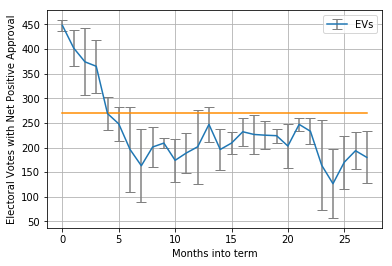

In [6]:
def labels(xlab, ylab): plt.xlabel(xlab); plt.ylabel(ylab); plt.grid(True); plt.legend()
    
def plot(states, dates, swing=4):
    N = len(dates)
    err = [EV(states, date, swing) - EV(states, date) for date in dates]
    plt.errorbar(range(N), [EV(states, date) for date in dates],
                 yerr=err, ecolor='grey', capsize=5, label='EVs')
    plt.plot(range(N), [270] * N, color='darkorange')
    labels('Months into term', 'Electoral Votes with Net Positive Approval')
    
plot(states, dates)

# Margin and country-wide net approval by month

The next plot gives the swing margin needed to reach 270 for each month, along with the country-wide net approval.

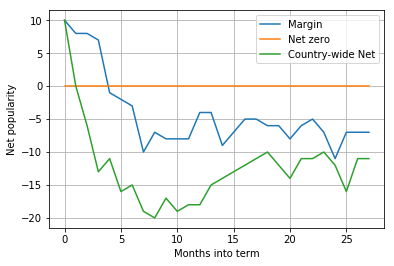

In [7]:
def plot2(states, dates):
    N = len(dates)
    plt.plot(range(N), [-margin(states, date) for date in dates], label='Margin')
    plt.plot(range(N), [0] * N, label='Net zero')
    plt.plot(range(N), [net_usa[date] for date in dates], label='Country-wide Net')
    labels('Months into term', 'Net popularity')
    
plot2(states, dates)

# Month-by-month summary

For each month, we show the expected electoral vote total (**EVs**), the swing margin needed to get to 270 (**Margin**), the overall (popular vote) net approval across the whole country (**Country**), and then the total percentage of undecided voters and in parentheses the number of states with at least 5% undecided.
Note that the country-wide vote is not all that correlated with the state-by-state margin: recently the state-by-state margin has held at 7% while the country-wide net approval has ranged from -10% to -16%, and when the state-by-state margin jumped to 11%, the country-wide measure stayed right in the middle at 12%.

In [8]:
def monthly(states, dates=reversed(dates)):
    yield '|   Month|EVs|Margin|Country|Undecided|'
    yield '|--------|---|------|-------|---------|'
    for date in dates:
        month = date.replace('1-', '').replace('-', ' 20')
        yield (f'|{month}|{int(EV(states, date))}|{margin(states, date)}%|{net_usa[date]}%'
               f'|{sum(s.ev * undecided(s, date) for s in states) / 538:.0f}% '
               f'({sum(undecided(s, date) > 5 for s in states)})|')
        
md(monthly(states))

|   Month|EVs|Margin|Country|Undecided|
|--------|---|------|-------|---------|
|Apr 2019|180|7%|-11%|4% (0)|
|Mar 2019|193|7%|-11%|4% (2)|
|Feb 2019|170|7%|-16%|4% (0)|
|Jan 2019|126|11%|-12%|4% (0)|
|Dec 2018|164|7%|-10%|5% (3)|
|Nov 2018|233|5%|-11%|4% (1)|
|Oct 2018|247|6%|-11%|4% (3)|
|Sep 2018|203|8%|-14%|4% (1)|
|Aug 2018|224|6%|-12%|4% (0)|
|Jul 2018|225|6%|-10%|4% (1)|
|Jun 2018|226|5%|-11%|4% (0)|
|May 2018|232|5%|-12%|4% (0)|
|Apr 2018|209|7%|-13%|4% (0)|
|Mar 2018|196|9%|-14%|4% (0)|
|Feb 2018|247|4%|-15%|4% (2)|
|Jan 2018|201|4%|-18%|5% (4)|
|Dec 2017|189|8%|-18%|5% (8)|
|Nov 2017|174|8%|-19%|5% (7)|
|Oct 2017|209|8%|-17%|5% (7)|
|Sep 2017|201|7%|-20%|5% (8)|
|Aug 2017|163|10%|-19%|7% (33)|
|Jul 2017|196|3%|-15%|5% (4)|
|Jun 2017|248|2%|-16%|5% (15)|
|May 2017|269|1%|-11%|5% (4)|
|Apr 2017|365|-7%|-13%|4% (4)|
|Mar 2017|374|-8%|-6%|5% (14)|
|Feb 2017|402|-8%|0%|6% (48)|
|Jan 2017|448|-10%|10%|11% (51)|

# State-by-state summary

Below is each state sorted by net approval, with the state's  maximum expected movement, and electoral vote allotment, followed by the cumulative running total of electoral votes and the percentages of  approval, dissaproval, and undecided, and finally the standard deviation of the net approval over the last 12 months. By going down the **Total** column, you can see what it takes to win. 

The **bold state names**  are the **swing states**, which I define as states in which the absolute value of net approval is less than two standard deviations of the net approval over time, plus a fifth of the undecided voters. The idea is that if we are just dealing with random sampling variation, you could expect future approval to be within two standard deviations 95% of the time, and if the undecideds split 60/40, then a candidate could get a net fifth of them. So it would be very unusual for the non-bold states to flip, unless some events change perception of the candidates.

This analysis says that if we consider all and only the bold swing states to be in play, then the total electoral votes for Trump could be anywhere in the range of 79 (if he lost them all) to 248 + 11 = 259 (if he won them all). It would take winning all the swing states plus a three-standard deviation swing in Virgina for Trump to reach 272.


In [9]:
def by_state(states, d=now):
    total = 0
    yield '|State|Net|Move|EV|Total|+|-|?|𝝈|'
    yield '|-----|---|----|--|-----|-|-|-|-|'
    for s in sorted(states, key=net, reverse=True):
        total += s.ev
        b = '**' if is_swing(s) else ''
        yield (f'|{b}{s.name}{b}|{b}{net(s):+d}%{b}|{b}{movement(s):.0f}%{b}|{s.ev}|{total}'
               f'|{s.apps[d]}%|{s.diss[d]}%|{undecided(s, now)}%|{𝝈(s):3.1f}%|')

md(by_state(states))

|State|Net|Move|EV|Total|+|-|?|𝝈|
|-----|---|----|--|-----|-|-|-|-|
|Wyoming|+28%|8%|3|3|62%|34%|4%|3.5%|
|Alabama|+26%|8%|9|12|61%|35%|4%|3.4%|
|Louisiana|+20%|8%|8|20|58%|38%|4%|3.7%|
|Mississippi|+20%|8%|6|26|58%|38%|4%|3.8%|
|West Virginia|+20%|8%|5|31|58%|38%|4%|3.6%|
|Tennessee|+18%|7%|11|42|57%|39%|4%|3.1%|
|Idaho|+17%|4%|4|46|57%|40%|3%|1.8%|
|Kentucky|+16%|3%|8|54|56%|40%|4%|1.1%|
|Oklahoma|+11%|7%|7|61|54%|43%|3%|3.4%|
|Arkansas|+10%|6%|6|67|53%|43%|4%|2.8%|
|South Carolina|+10%|5%|9|76|53%|43%|4%|2.2%|
|South Dakota|+10%|9%|3|79|53%|43%|4%|4.3%|
|**North Dakota**|**+6%**|**6%**|3|82|51%|45%|4%|2.8%|
|**Utah**|**+5%**|**8%**|6|88|51%|46%|3%|3.6%|
|**Indiana**|**+4%**|**5%**|11|99|50%|46%|4%|2.0%|
|**Missouri**|**+4%**|**7%**|10|109|50%|46%|4%|3.0%|
|**Nebraska**|**+4%**|**6%**|5|114|50%|46%|4%|2.7%|
|**Texas**|**+4%**|**6%**|38|152|50%|46%|4%|2.6%|
|**Georgia**|**+3%**|**7%**|16|168|49%|46%|5%|3.2%|
|**Montana**|**+3%**|**7%**|3|171|50%|47%|3%|3.4%|
|**Kansas**|**+2%**|**7%**|6|177|49%|47%|4%|2.9%|
|**Alaska**|**+1%**|**11%**|3|180|48%|47%|5%|5.1%|
|**Florida**|**-2%**|**7%**|29|209|47%|49%|4%|3.3%|
|**North Carolina**|**-2%**|**5%**|15|224|47%|49%|4%|2.2%|
|**Ohio**|**-4%**|**6%**|18|242|46%|50%|4%|2.4%|
|**Nevada**|**-6%**|**7%**|6|248|45%|51%|4%|3.1%|
|Virginia|-6%|4%|13|261|45%|51%|4%|1.8%|
|Pennsylvania|-7%|4%|20|281|45%|52%|3%|1.6%|
|**Arizona**|**-8%**|**8%**|11|292|44%|52%|4%|3.7%|
|Iowa|-8%|6%|6|298|44%|52%|4%|2.6%|
|Michigan|-10%|5%|16|314|43%|53%|4%|2.2%|
|New Mexico|-12%|7%|5|319|42%|54%|4%|2.9%|
|Colorado|-13%|5%|9|328|42%|55%|3%|2.4%|
|Minnesota|-13%|5%|10|338|42%|55%|3%|2.2%|
|Wisconsin|-13%|5%|10|348|42%|55%|3%|2.4%|
|Delaware|-15%|5%|3|351|41%|56%|3%|2.0%|
|Maine|-15%|9%|4|355|41%|56%|3%|4.0%|
|New Jersey|-17%|5%|14|369|40%|57%|3%|2.4%|
|New Hampshire|-19%|8%|4|373|39%|58%|3%|3.6%|
|Illinois|-22%|3%|20|393|37%|59%|4%|1.2%|
|Oregon|-22%|5%|7|400|37%|59%|4%|2.0%|
|Rhode Island|-22%|6%|4|404|37%|59%|4%|2.8%|
|Connecticut|-23%|8%|7|411|37%|60%|3%|3.8%|
|New York|-24%|4%|29|440|36%|60%|4%|1.8%|
|Washington|-26%|5%|12|452|35%|61%|4%|2.1%|
|Massachusetts|-28%|5%|11|463|34%|62%|4%|2.2%|
|California|-29%|7%|55|518|34%|63%|3%|3.1%|
|Maryland|-30%|8%|10|528|33%|63%|4%|3.5%|
|Hawaii|-34%|9%|4|532|31%|65%|4%|4.2%|
|Vermont|-37%|10%|3|535|30%|67%|3%|4.8%|
|District of Columbia|-60%|7%|3|538|18%|78%|4%|3.1%|